In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import holidays
import datetime
import os

2023-11-28 22:12:18.872954: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 22:12:18.889963: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 22:12:18.889988: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 22:12:18.889999: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 22:12:18.893615: I tensorflow/core/platform/cpu_feature_g

In [2]:
tf.config.list_physical_devices('GPU')


2023-11-28 22:12:20.145792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 22:12:20.148432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 22:12:20.148454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
energy_df = pd.read_csv('energiedaten3.csv', sep=';', decimal=',')
energy_df['zeit'] = pd.to_datetime(energy_df['zeit'], format='%d.%m.%Y %H:%M')
timestamp_s = energy_df['zeit'].map(pd.Timestamp.timestamp)
energy_df


,zeit,stromverbrauch
0,2017-01-01 00:15:00,6.28
1,2017-01-01 00:30:00,6.12
2,2017-01-01 00:45:00,6.48
3,2017-01-01 01:00:00,6.12
4,2017-01-01 01:15:00,6.24
...,...,...
207475,2022-12-01 23:00:00,9.20
207476,2022-12-01 23:15:00,8.56
207477,2022-12-01 23:30:00,7.40
207478,2022-12-01 23:45:00,7.24


In [4]:
day = 24*60*60
year = (365.2425)*day

#Sinus/Cos hinzufügen
energy_df['Day sin'] = np.sin(timestamp_s * ( 2* np.pi / day))
energy_df['Day cos'] = np.cos(timestamp_s * (2* np.pi / day))
energy_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
energy_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#Wochentag hinzufügen
energy_df.index=pd.to_datetime(energy_df['zeit'],format='%d.%m.%Y %H:%M')
energy_df['wochentag']=energy_df['zeit'].dt.dayofweek
energy_df

,zeit,stromverbrauch,Day sin,Day cos,Year sin,Year cos,wochentag
zeit,,,,,,,
2017-01-01 00:15:00,2017-01-01 00:15:00,6.28,6.540313e-02,0.997859,0.010544,0.999944,6
2017-01-01 00:30:00,2017-01-01 00:30:00,6.12,1.305262e-01,0.991445,0.010723,0.999943,6
2017-01-01 00:45:00,2017-01-01 00:45:00,6.48,1.950903e-01,0.980785,0.010902,0.999941,6
2017-01-01 01:00:00,2017-01-01 01:00:00,6.12,2.588190e-01,0.965926,0.011081,0.999939,6
2017-01-01 01:15:00,2017-01-01 01:15:00,6.24,3.214395e-01,0.946930,0.011260,0.999937,6
...,...,...,...,...,...,...,...
2022-12-01 23:00:00,2022-12-01 23:00:00,9.20,-2.588190e-01,0.965926,-0.491893,0.870656,3
2022-12-01 23:15:00,2022-12-01 23:15:00,8.56,-1.950903e-01,0.980785,-0.491737,0.870744,3
2022-12-01 23:30:00,2022-12-01 23:30:00,7.40,-1.305262e-01,0.991445,-0.491581,0.870832,3


In [5]:
#Normalisieren
max_sum_kWh =energy_df['stromverbrauch'].max()
max_sum_kWh 
energy_df['stromverbrauch'] = energy_df['stromverbrauch'] / max_sum_kWh

#Datentyp umwandeln
energy_df['stromverbrauch'] = energy_df['stromverbrauch'].astype(float)

#Durchschnittlicherverbrauch pro WochenTag und hinzufügen  in Dataframe
average_consumption_by_weekday = energy_df.groupby('wochentag')['stromverbrauch'].mean()
energy_df['Average Consumption'] = energy_df['wochentag'].map(average_consumption_by_weekday)

#Spalten löschen
columns_to_drop= ['zeit','wochentag']
energy_df=energy_df.drop(columns_to_drop, axis=1)
energy_df


,stromverbrauch,Day sin,Day cos,Year sin,Year cos,Average Consumption
zeit,,,,,,
2017-01-01 00:15:00,0.080266,6.540313e-02,0.997859,0.010544,0.999944,0.094065
2017-01-01 00:30:00,0.078221,1.305262e-01,0.991445,0.010723,0.999943,0.094065
2017-01-01 00:45:00,0.082822,1.950903e-01,0.980785,0.010902,0.999941,0.094065
2017-01-01 01:00:00,0.078221,2.588190e-01,0.965926,0.011081,0.999939,0.094065
2017-01-01 01:15:00,0.079755,3.214395e-01,0.946930,0.011260,0.999937,0.094065
...,...,...,...,...,...,...
2022-12-01 23:00:00,0.117587,-2.588190e-01,0.965926,-0.491893,0.870656,0.175431
2022-12-01 23:15:00,0.109407,-1.950903e-01,0.980785,-0.491737,0.870744,0.175431
2022-12-01 23:30:00,0.094581,-1.305262e-01,0.991445,-0.491581,0.870832,0.175431


In [6]:
#Tempeartur von 2019 einfügen
temp_df = pd.read_csv('Temperaturdaten_WT_19.csv', sep=';', decimal=',', encoding='latin1')
temp_df['time'] = pd.to_datetime(temp_df['time'], format='%d.%m.%Y %H:%M')

#Zeit als Index
temp_df.index=pd.to_datetime(temp_df['time'],format='%d.%m.%Y %H:%M')

temp_df


,time,Temp [°C]
time,,
2019-01-01 00:00:00,2019-01-01 00:00:00,7.50
2019-01-01 01:00:00,2019-01-01 01:00:00,7.60
2019-01-01 02:00:00,2019-01-01 02:00:00,7.10
2019-01-01 03:00:00,2019-01-01 03:00:00,6.90
2019-01-01 04:00:00,2019-01-01 04:00:00,6.80
...,...,...
2019-12-31 19:00:00,2019-12-31 19:00:00,-1.40
2019-12-31 20:00:00,2019-12-31 20:00:00,-1.40
2019-12-31 21:00:00,2019-12-31 21:00:00,-0.90


In [7]:
#Zeitbereich überprüfen
print("energy_df Zeitbereich:")
print(energy_df.index.min(), "bis", energy_df.index.max())

print("\ntemp_df Zeitbereich:")
print(temp_df.index.min(), "bis", temp_df.index.max())

energy_df Zeitbereich:
2017-01-01 00:15:00 bis 2022-12-02 00:00:00

temp_df Zeitbereich:
2019-01-01 00:00:00 bis 2019-12-31 23:00:00


In [8]:
#Energy_df und Temp_df verknüpfen
energy_df['temperatur_2019'] = temp_df['Temp [°C]']
energy_df['temperatur_2019'] = energy_df['temperatur_2019'].interpolate(method='time', limit_area='inside')

#Für nur Daten Aus 2019
# energy_df.dropna(inplace=True)


,stromverbrauch,Day sin,Day cos,Year sin,Year cos,Average Consumption,temperatur_2019
zeit,,,,,,,
2017-01-01 00:15:00,0.080266,6.540313e-02,0.997859,0.010544,0.999944,0.094065,NaN
2017-01-01 00:30:00,0.078221,1.305262e-01,0.991445,0.010723,0.999943,0.094065,NaN
2017-01-01 00:45:00,0.082822,1.950903e-01,0.980785,0.010902,0.999941,0.094065,NaN
2017-01-01 01:00:00,0.078221,2.588190e-01,0.965926,0.011081,0.999939,0.094065,NaN
2017-01-01 01:15:00,0.079755,3.214395e-01,0.946930,0.011260,0.999937,0.094065,NaN
...,...,...,...,...,...,...,...
2022-12-01 23:00:00,0.117587,-2.588190e-01,0.965926,-0.491893,0.870656,0.175431,NaN
2022-12-01 23:15:00,0.109407,-1.950903e-01,0.980785,-0.491737,0.870744,0.175431,NaN
2022-12-01 23:30:00,0.094581,-1.305262e-01,0.991445,-0.491581,0.870832,0.175431,NaN


In [9]:
# Ausgabe der Zeilen mit den 10 höchsten Werten
top_10_temperatures = energy_df.nlargest(10, 'temperatur_2019')

print(top_10_temperatures)


                     stromverbrauch       Day sin   Day cos  Year sin  \
zeit                                                                    
2019-07-25 13:00:00        0.130368 -2.588190e-01 -0.965926 -0.386023   
2019-07-25 13:15:00        0.134458 -3.214395e-01 -0.946930 -0.386188   
2019-07-25 13:30:00        0.145194 -3.826834e-01 -0.923880 -0.386353   
2019-07-25 12:45:00        0.145194 -1.950903e-01 -0.980785 -0.385857   
2019-07-25 13:45:00        0.134458 -4.422887e-01 -0.896873 -0.386519   
2019-07-25 14:00:00        0.131902 -5.000000e-01 -0.866025 -0.386684   
2019-07-25 12:30:00        0.142127 -1.305262e-01 -0.991445 -0.385692   
2019-07-25 14:15:00        0.132924 -5.555702e-01 -0.831470 -0.386849   
2019-07-25 12:15:00        0.150818 -6.540313e-02 -0.997859 -0.385527   
2019-07-25 12:00:00        0.159509  2.071279e-12 -1.000000 -0.385361   

                     Year cos  Average Consumption  temperatur_2019  
zeit                                                 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, regularizers
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler

# Aufteilung in Features und Labels
X = energy_df[['stromverbrauch','Day sin', 'Day cos', 'Year sin', 'Year cos', 'Average Consumption']]        #Wenn man Stromverbrauch rauslässt trotzdem gute Ergebnisse ,'temperatur_2019'
y = energy_df['stromverbrauch']

# Normierung der Daten (z.B. Min-Max-Skalierung)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Sequenzbildung
sequence_length = 1000                                                                                                           #Beispiel: Sequenzen von 10 aufeinander folgenden Zeitschritten
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - sequence_length):    
   X_sequences.append(X_scaled[i:i+sequence_length, :])
   y_sequences.append(y.iloc[i+sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)
#Aufteilung in 30 Test 
# Festlegung der Größe für Training und Test
train_size = int(0.95 * len(X_sequences))
test_size = 2
val_size = len(X_sequences) - train_size - test_size

# Aufteilung in Trainings-, Validierungs- und Testdatensätze
X_train = X_sequences[:train_size]
y_train = y_sequences[:train_size]

X_val = X_sequences[train_size:train_size+val_size]
y_val = y_sequences[train_size:train_size+val_size]

X_test = X_sequences[train_size+val_size:train_size+val_size+test_size]
y_test = y_sequences[train_size+val_size:train_size+val_size+test_size]


# Überprüfen der Shape der Datensätze
print("Trainingsdaten:", X_train.shape, y_train.shape)
print("Validierungsdaten:", X_val.shape, y_val.shape)
print("Testdaten:", X_test.shape, y_test.shape)

Trainingsdaten: (196156, 1000, 6) (196156,)
Validierungsdaten: (10322, 1000, 6) (10322,)
Testdaten: (2, 1000, 6) (2,)


In [11]:
#Funktion Definieren, sodass gesamte Spalte betrachtet und Stromverbrauch Ausgangswert
window_size = sequence_length


def df_to_X_y1(df, window_size=window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]            
    X.append(row)
    label = df_as_np[i+window_size][0]                      
    y.append(label)
  return np.array(X), np.array(y)



#IF Schleife wenn Implementierbar?



In [12]:
#LSTM Model erstellen mit angepassten Input Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError                         #Sum of all Squared differences
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import  load_model



model_lstm_fwsh=Sequential()
#7 Timestamps/Windowsize wird nicht besser mit mehr Windows  11 relevante Variablen
model_lstm_fwsh.add(InputLayer(input_shape=(window_size,6)))  
model_lstm_fwsh.add(LSTM(100, return_sequences=True))
model_lstm_fwsh.add(LSTM(50))
model_lstm_fwsh.add(Dense(16))
model_lstm_fwsh.add(Dense(8, 'relu'))                       # Hochskalieren= Anzahl der Neuronen  erhöhen
# Ausgabewerte  1
model_lstm_fwsh.add(Dense(1,'linear'))
model_lstm_fwsh.summary()

2023-11-28 22:12:23.620942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 22:12:23.620983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 22:12:23.620995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 22:12:23.775273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 22:12:23.775308: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 100)         42800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 73961 (288.91 KB)
Trainable params: 73961 (288.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-11-28 22:12:24.290231: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [13]:
# Verzeichnis für das Modell erstellen
model_lstm_fwsh_save_path = r'C:\Users\Tobi\Desktop\Uni\Bachaelorarbeit\Projekte\Tensorflow 2.0\Model CP'
if not os.path.exists(model_lstm_fwsh_save_path):
    os.makedirs(model_lstm_fwsh_save_path)

In [14]:
# ModelCheckpoint Callback erstellen
checkpoint_filepath = os.path.join(model_lstm_fwsh_save_path, 'model_lstm_fwsh_checkpoint.h5')
cp = ModelCheckpoint(checkpoint_filepath, save_best_only=True)

In [15]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model_lstm_fwsh.compile(optimizer=optimizer, loss="MSE", metrics=["MAE"])
model_lstm_fwsh.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])


Epoch 1/10


2023-11-28 22:12:30.492394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-28 22:12:30.745281: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f41a0040f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 22:12:30.745304: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-11-28 22:12:30.751206: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-28 22:12:30.812479: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6130/6130 [==============================] - 344s 56ms/step - loss: 0.0021 - MAE: 0.0273 - val_loss: 0.0021 - val_MAE: 0.0247
Epoch 2/10
   2/6130 [..............................] - ETA: 5:14 - loss: 9.2040e-04 - MAE: 0.0229

/home/tobias/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6130/6130 [==============================] - 337s 55ms/step - loss: 0.0013 - MAE: 0.0204 - val_loss: 0.0015 - val_MAE: 0.0231
Epoch 3/10
6130/6130 [==============================] - 336s 55ms/step - loss: 0.0011 - MAE: 0.0186 - val_loss: 0.0014 - val_MAE: 0.0183
Epoch 4/10
6130/6130 [==============================] - 337s 55ms/step - loss: 0.0011 - MAE: 0.0182 - val_loss: 0.0013 - val_MAE: 0.0169
Epoch 5/10
6130/6130 [==============================] - 339s 55ms/step - loss: 0.0011 - MAE: 0.0179 - val_loss: 0.0013 - val_MAE: 0.0173
Epoch 6/10
6130/6130 [==============================] - 342s 56ms/step - loss: 0.0011 - MAE: 0.0177 - val_loss: 0.0014 - val_MAE: 0.0190
Epoch 7/10
6130/6130 [==============================] - 337s 55ms/step - loss: 0.0010 - MAE: 0.0176 - val_loss: 0.0013 - val_MAE: 0.0170
Epoch 8/10
6130/6130 [==============================] - 340s 55ms/step - loss: 0.0010 - MAE: 0.0174 - val_loss: 0.0013 - val_MAE: 0.0167
Epoch 9/10
6130/6130 [==============================

In [16]:
# Modell speichern 

model_lstm_fwsh.save(os.path.join(model_lstm_fwsh_save_path, 'my_model_lstm_fwsh.h5'))

In [17]:
# Modell wieder abrufen
loaded_model_lstm_fwsh = load_model(os.path.join(model_lstm_fwsh_save_path, 'my_model_lstm_fwsh.h5'))


6130/6130 [==============================] - 151s 24ms/step


,Train Predictions,Actuals
zeit,,
2017-01-01 00:15:00,45.733299,34.48
2017-01-01 00:30:00,38.446335,47.48
2017-01-01 00:45:00,49.242931,50.44
2017-01-01 01:00:00,49.056702,52.64
2017-01-01 01:15:00,51.558418,54.24
...,...,...
2022-08-06 01:00:00,33.929588,29.12
2022-08-06 01:15:00,32.020393,33.60
2022-08-06 01:30:00,34.846222,33.04


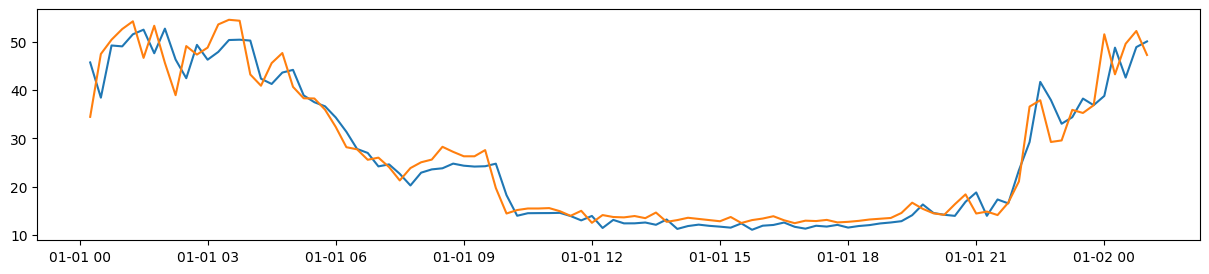

In [18]:
#Training anzeigen

train_predictions =model_lstm_fwsh.predict(X_train).flatten() #Vektor of Predicitions, flatten=> ohne inner Brackets  , nicht extra train_predictions1 da sonst nicht für nächste Modelle angewandt
y_train=y_train.ravel() 
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
# Rückgängig machen der Normalisierung
train_results['Train Predictions'] = train_results['Train Predictions'] * max_sum_kWh
train_results['Actuals'] = train_results['Actuals'] * max_sum_kWh

#Index anpassen
train_results.index = energy_df.index[:196156  ]

plt.figure(figsize=(15, 3))
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])
train_results

323/323 [==============================] - 8s 23ms/step


,Val Predictions,Actuals
zeit,,
2022-08-06 02:15:00,33.734764,28.00
2022-08-06 02:30:00,29.722797,24.28
2022-08-06 02:45:00,27.204010,31.48
2022-08-06 03:00:00,31.091898,32.12
2022-08-06 03:15:00,30.687063,31.96
...,...,...
2022-11-21 12:30:00,7.224602,8.24
2022-11-21 12:45:00,7.522859,7.16
2022-11-21 13:00:00,6.562027,9.20


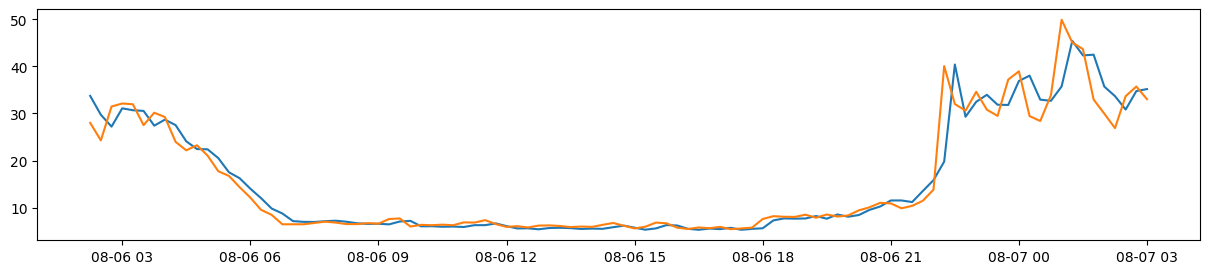

In [19]:
val_predictions= model_lstm_fwsh.predict(X_val).flatten()
y_val=y_val.ravel() #y_val in 1D-Array sonst: ValueError: Per-column arrays must each be 1-dimensional
val_results = pd.DataFrame(data={'Val Predictions':val_predictions,'Actuals':y_val})



# Rückgängig machen der Normalisierung
val_results['Val Predictions'] = val_results['Val Predictions'] * max_sum_kWh
val_results['Actuals'] = val_results['Actuals'] * max_sum_kWh

#Index anpassen
val_results.index = energy_df.index[196156:206478]


plt.figure(figsize=(15, 3))
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

val_results

1/1 [==============================] - 0s 52ms/step


,Test Predictions,Actuals
zeit,,
2022-12-01 23:45:00,6.696533,7.24
2022-12-02 00:00:00,6.546339,7.96


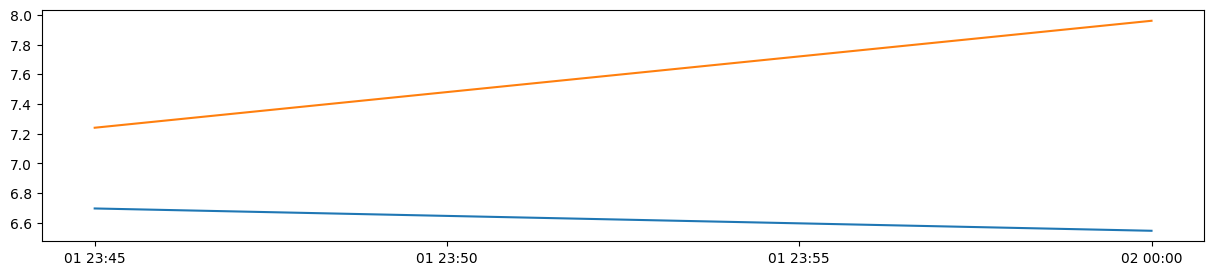

In [20]:
#Test= Endgültige Bewertung des Modells anhand völlig unbekannter Daten
test_predictions= model_lstm_fwsh.predict(X_test).flatten()
y_test=y_test.ravel() 
test_results = pd.DataFrame(data={'Test Predictions':test_predictions,'Actuals':y_test})

# Rückgängig machen der Normalisierung
test_results['Test Predictions'] = test_results['Test Predictions'] * max_sum_kWh
test_results['Actuals'] = test_results['Actuals'] * max_sum_kWh

#Index anpassen
test_results.index = energy_df.index[207478:]


plt.figure(figsize=(15, 3)) 

plt.plot(test_results['Test Predictions']) #[2400:2600]

plt.plot(test_results['Actuals']) #[2400:2600]

test_results

In [21]:
#Accuracy ausgeben https://chat.openai.com/c/e2c208bd-30e0-4f5d-97e0-94b8889dd4ad
test_loss, test_accuracy = model_lstm_fwsh.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


1/1 [==============================] - 0s 82ms/step - loss: 1.8736e-04 - MAE: 0.0125
Test Accuracy: 0.012507211416959763


To do :
-Temperatur implementieren über if
-accuracy prüfen Prediction/Actual vergleichen und Summe durch Anzahl.
-Sample Size auf 1 Jahr skalieren und Patch Size/sequence_length klein halten

Neue daten mit der selben Struktur implementieren
#model1= load_model('model1')
# prediction = loaded_model.predict(new_data)